In [62]:
import tensorflow as tf # 2.3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.callbacks import EarlyStopping

Import les donées 导入数据

In [67]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

In [68]:

train_image = train_image[0:6000]
test_image = test_image[0:1000]
train_labels = train_labels[0:6000]
test_labels = test_labels[0:1000]

In [69]:
train_image = tf.pad(train_image, [[0, 0], [2,2], [2,2]])
test_image = tf.pad(test_image, [[0, 0], [2,2], [2,2]])

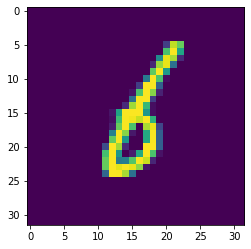

In [70]:
import matplotlib.pyplot as plt
image = train_image[256]
plt.imshow(image)
plt.show()

Traitement les données 数据处理

In [71]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = train_image/255 # 把0-255的数据范围变为-1到1之间
test_image = test_image/255 # 把0-255的数据范围变为-1到1之间

# Augmenter la dimension du canal 增加通道维度
#train_image = tf.expand_dims(train_image, -1)
#test_image = tf.expand_dims(test_image, -1)
# train_image.shape = ([60000, 28, 28, 1]), train_labels.shape = (60000,)

# Transformation de type 类型转换
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données 创建数据集

In [72]:
# 创建Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(6000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

## Construire le modèle MLP et l'entraîner 搭建MLP模型并训练

In [73]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(32, 32,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 100)              

In [74]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
callbacks = [EarlyStopping(patience=2)]


In [75]:
history = model.fit(dataset, epochs=10, validation_data=test_dataset, callbacks = callbacks)
#history = model.fit(dataset,validation_data=test_dataset,epochs=10) # 返回字典类型的数据 其中记录了准确率和损失的信息

Epoch 1/10
24/24 [==============================] - 9s 342ms/step - loss: 1.2495 - acc: 0.6470 - val_loss: 0.5179 - val_acc: 0.8420
Epoch 2/10
24/24 [==============================] - 8s 334ms/step - loss: 0.4212 - acc: 0.8730 - val_loss: 0.3320 - val_acc: 0.8980
Epoch 3/10
24/24 [==============================] - 8s 335ms/step - loss: 0.2709 - acc: 0.9202 - val_loss: 0.2380 - val_acc: 0.9260
Epoch 4/10
24/24 [==============================] - 9s 365ms/step - loss: 0.2115 - acc: 0.9357 - val_loss: 0.1848 - val_acc: 0.9400
Epoch 5/10
24/24 [==============================] - 9s 391ms/step - loss: 0.1622 - acc: 0.9522 - val_loss: 0.1545 - val_acc: 0.9500
Epoch 6/10
24/24 [==============================] - 8s 332ms/step - loss: 0.1232 - acc: 0.9623 - val_loss: 0.1277 - val_acc: 0.9550
Epoch 7/10
24/24 [==============================] - 8s 331ms/step - loss: 0.1034 - acc: 0.9695 - val_loss: 0.1131 - val_acc: 0.9600
Epoch 8/10
24/24 [==============================] - 8s 331ms/step - loss: 0.

##Implémenter FGSM(Fast Gradient Sign Method)
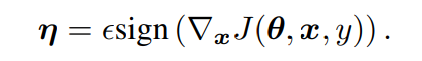

In [88]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [77]:
perturbations = create_adversarial_pattern(test_image, test_labels)

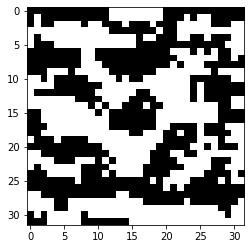

In [78]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

Définir une fonction pour plot les images

In [79]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette true par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
  for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
      plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
      plt.imshow(image[i,:,:],cmap='gray') # + 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off') # 不要坐标
  plt.show()


##Ajouter la perturbations et Tester dans le jeu de test

epsilons = 0:
32/32 [==============================] - 0s 14ms/step


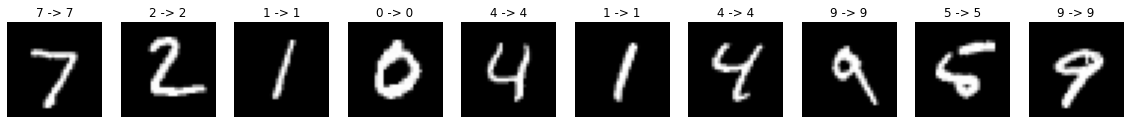

epsilons = 0.05:
32/32 [==============================] - 0s 15ms/step


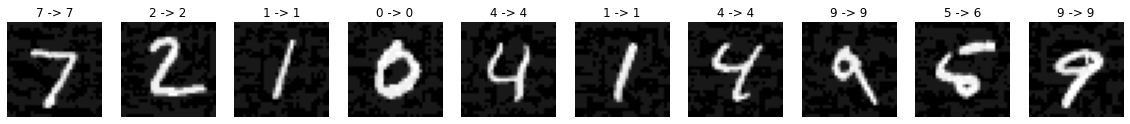

epsilons = 0.1:
32/32 [==============================] - 0s 15ms/step


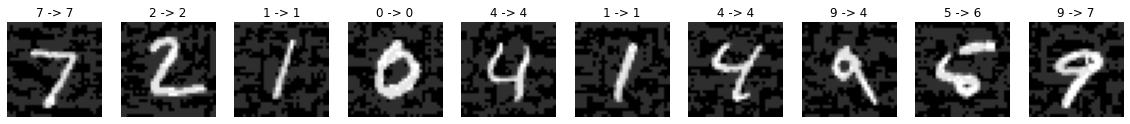

epsilons = 0.15:
32/32 [==============================] - 0s 14ms/step


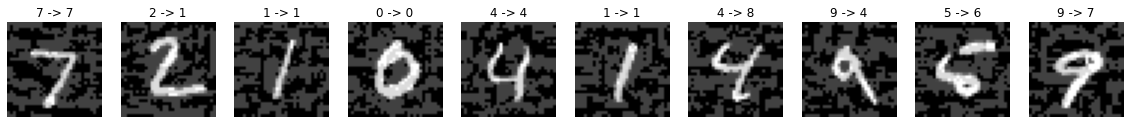

epsilons = 0.2:
32/32 [==============================] - 0s 14ms/step


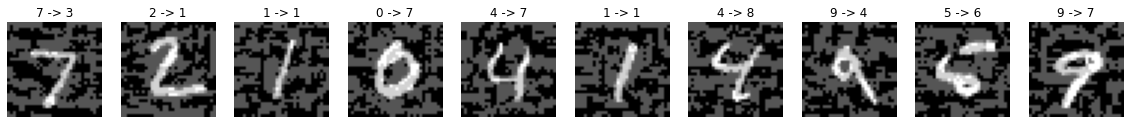

epsilons = 0.25:
32/32 [==============================] - 0s 15ms/step


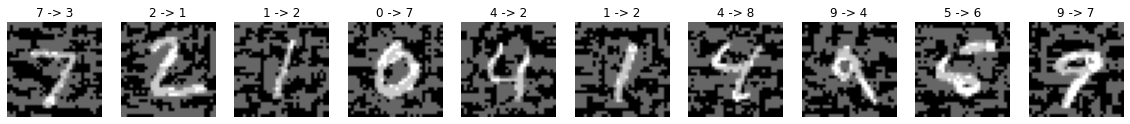

epsilons = 0.3:
32/32 [==============================] - 1s 15ms/step


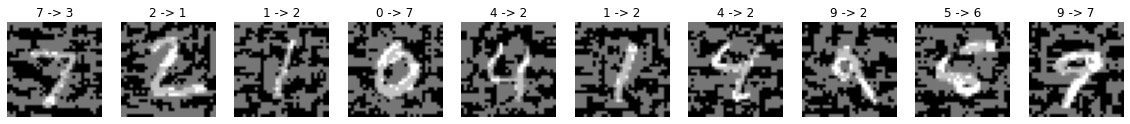

In [80]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

Afficher la précision en fonction d'epsilons

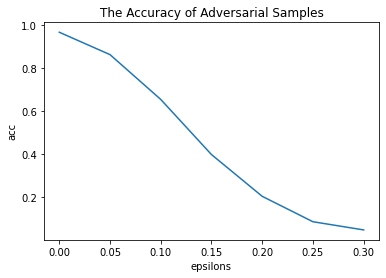

acc [0.9660000205039978, 0.8619999885559082, 0.6539999842643738, 0.39800000190734863, 0.20399999618530273, 0.0860000029206276, 0.04800000041723251]
epsilons [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [81]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list)
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)

In [82]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #对抗训练集 = 原训练集+加了扰动的训练集 （120000 images） 
print(np.shape(train_train_adv))
labels_label_adv = tf.concat([train_labels, train_labels], 0)  #labels = 2*原labels，因为加了扰动的图像还属于该标签

(12000, 32, 32)


In [83]:
dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(12000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [84]:
model_adv = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
model_adv.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 100)              

In [85]:
optimizer_adv = tf.keras.optimizers.Adam()
loss_func_adv = tf.keras.losses.SparseCategoricalCrossentropy()
model_adv.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
callbacks = [EarlyStopping(patience=2)]

In [86]:
history = model_adv.fit(dataset_adv, epochs=10, validation_data=test_dataset, callbacks = callbacks)
#history = model.fit(dataset,validation_data=test_dataset,epochs=10) # 返回字典类型的数据 其中记录了准确率和损失的信息

Epoch 1/10
47/47 [==============================] - 18s 380ms/step - loss: 0.6207 - acc: 0.8033 - val_loss: 0.2732 - val_acc: 0.9140
Epoch 2/10
47/47 [==============================] - 17s 360ms/step - loss: 0.1042 - acc: 0.9670 - val_loss: 0.1583 - val_acc: 0.9520
Epoch 3/10
47/47 [==============================] - 17s 364ms/step - loss: 0.0666 - acc: 0.9808 - val_loss: 0.1055 - val_acc: 0.9630
Epoch 4/10
47/47 [==============================] - 20s 420ms/step - loss: 0.0503 - acc: 0.9843 - val_loss: 0.0964 - val_acc: 0.9640
Epoch 5/10
47/47 [==============================] - 17s 353ms/step - loss: 0.0365 - acc: 0.9893 - val_loss: 0.0732 - val_acc: 0.9690
Epoch 6/10
47/47 [==============================] - 17s 355ms/step - loss: 0.0297 - acc: 0.9917 - val_loss: 0.0733 - val_acc: 0.9770
Epoch 7/10
47/47 [==============================] - 17s 354ms/step - loss: 0.0245 - acc: 0.9923 - val_loss: 0.0705 - val_acc: 0.9700
Epoch 8/10
47/47 [==============================] - 17s 353ms/step - 

epsilons = 0:
32/32 [==============================] - 1s 14ms/step


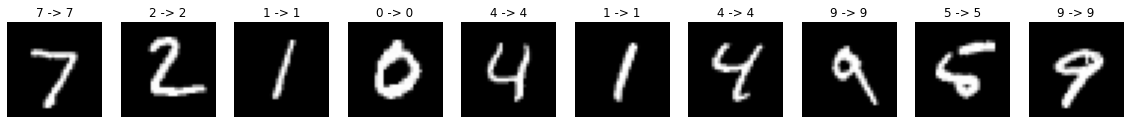

epsilons = 0.05:
32/32 [==============================] - 0s 14ms/step


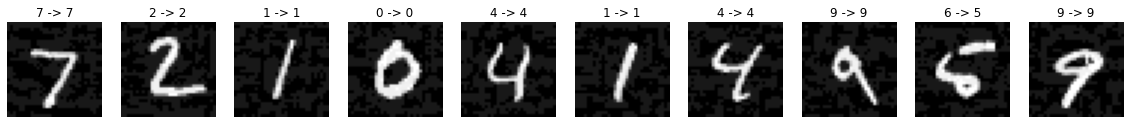

epsilons = 0.1:
32/32 [==============================] - 0s 14ms/step


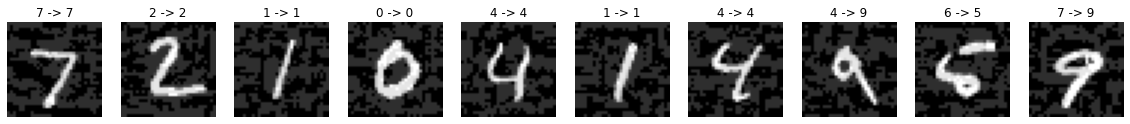

epsilons = 0.15:
32/32 [==============================] - 0s 14ms/step


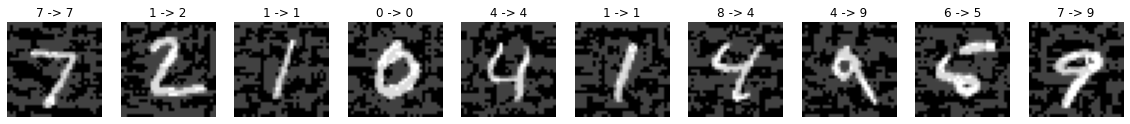

epsilons = 0.2:
32/32 [==============================] - 0s 15ms/step


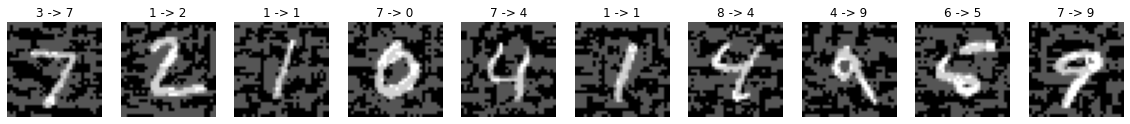

epsilons = 0.25:
32/32 [==============================] - 0s 15ms/step


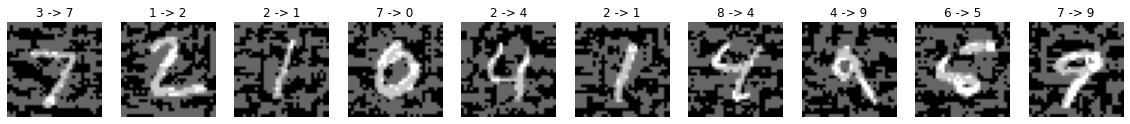

epsilons = 0.3:
32/32 [==============================] - 0s 15ms/step


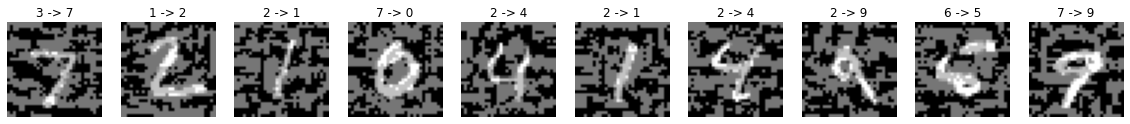

In [87]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  adv_image = test_image + eps*perturbations      # 对抗样本测试集=测试集加上干扰
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  #test_image = tf.clip_by_value(adv_image, -1, 1)
  predict_label = model.predict(adv_image) 
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_predict_label = model_adv.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

  ## 输出标签：原模型对对抗样例的预测 -> 用对抗训练的模型对对抗样例的预测

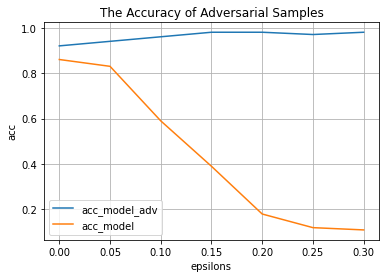

acc [0.9200000166893005, 0.9399999976158142, 0.9599999785423279, 0.9800000190734863, 0.9800000190734863, 0.9700000286102295, 0.9800000190734863]
epsilons [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [61]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)